# Demo for NeRFFaceLighting
- Include the Image Generation, Video Exportation of the Interpolation of Lighting, Shape Exportation.
- Include the FID, Lighting Error, Lighting Error_unseen, Lighting Stability Evaluation.

## Define the Settings

Setting up which GPU you are using.

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

If you encounter error while building the plugins for StyleGAN2, it may probably be caused by the missing path of ninja. Thus, explicitly adding the path of ninja to the `PATH` environment variable may help.

You can query the path by typing `which ninja` in the conda environment and extract the directory component.

In [2]:
# Uncomment this line if you encounter the error (at least worth a try ;D)
# os.environ['PATH'] = os.environ['PATH'] + ":path-to-ninja(directory only)"

In [4]:
device = "cuda"

## Define the Utility Functions

In [5]:
import cv2
import dnnlib
import torch
import pickle
import mrcfile
import pyshtools
import numpy as np
from PIL import Image
from tqdm import tqdm
from typing import List, Optional, Tuple, Union

import imageio
from torchvision import transforms
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
from camera_utils import LookAtPoseSampler, FOV_to_intrinsics

import warnings
warnings.filterwarnings("ignore")

In [6]:
imageio.plugins.freeimage.download()

In [7]:
from shape_utils import create_samples, extract_mrc

In [8]:
@torch.no_grad()
def render_tensor(img: torch.Tensor, normalize: bool = True, nrow: int = 8) -> Image.Image:
    if type(img) == list:
        img = torch.cat(img, dim=0).expand(-1, 3, -1, -1)
    elif len(img.shape) == 3:
        img = img.expand(3, -1, -1)
    elif len(img.shape) == 4:
        img = img.expand(-1, 3, -1, -1)
    
    img = img.squeeze()
    
    if normalize:
        img = img / 2 + .5
    
    if len(img.shape) == 3:
        return Image.fromarray((img.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 2:
        return Image.fromarray((img.cpu().numpy() * 255).astype(np.uint8))
    elif len(img.shape) == 4:
        return Image.fromarray((make_grid(img, nrow=nrow).permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8))

In [9]:
def to_tensor(img: Union[Image.Image, np.ndarray], normalize=True) -> torch.Tensor:
    if isinstance(img, Image.Image):
        img = np.array(img)
        if len(img.shape) > 2:
            img = img.transpose(2, 0, 1)
        else:
            img = img[None, ...]
    else:
        if img.shape[0] == img.shape[1]:
            img = img.transpose(2, 0, 1)
    if normalize:
        img = torch.from_numpy(img).to(torch.float32) / 127.5 - 1
    else:
        img = torch.from_numpy(img).to(torch.float32) / 255.
    return img[None, ...].to(device)

In [10]:
def _normal(img_size):
    x = np.linspace(-1, 1, img_size)
    z = np.linspace(1, -1, img_size)
    x, z = np.meshgrid(x, z)

    mag = np.sqrt(x**2 + z**2)
    valid = mag <=1
    y = -np.sqrt(1 - (x*valid)**2 - (z*valid)**2)
    x = x * valid
    y = y * valid
    z = z * valid
    normal = np.concatenate((x[...,None], y[...,None], z[...,None]), axis=2)
    normal = np.reshape(normal, (-1, 3))
    return normal

NORMAL = _normal(256)

def _basis(normal):
    numElem = normal.shape[0]

    norm_X = normal[:,0]
    norm_Y = normal[:,1]
    norm_Z = normal[:,2]

    sh_basis = np.zeros((numElem, 9))
    att= np.pi*np.array([1, 2.0/3.0, 1/4.0])
    sh_basis[:,0] = 0.5/np.sqrt(np.pi)*att[0]

    sh_basis[:,1] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_Y*att[1]
    sh_basis[:,2] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_Z*att[1]
    sh_basis[:,3] = np.sqrt(3)/2/np.sqrt(np.pi)*norm_X*att[1]

    sh_basis[:,4] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_Y*norm_X*att[2]
    sh_basis[:,5] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_Y*norm_Z*att[2]
    sh_basis[:,6] = np.sqrt(5)/4/np.sqrt(np.pi)*(3*norm_Z**2-1)*att[2]
    sh_basis[:,7] = np.sqrt(15)/2/np.sqrt(np.pi)*norm_X*norm_Z*att[2]
    sh_basis[:,8] = np.sqrt(15)/4/np.sqrt(np.pi)*(norm_X**2-norm_Y**2)*att[2]
    return sh_basis

def _shading(normal, SH):
    sh_basis = _basis(normal)
    shading = np.matmul(sh_basis, SH)
    return shading

@torch.no_grad()
def render_shading(sh):
    shading = _shading(NORMAL, sh.cpu().numpy().squeeze())
    value = np.percentile(shading, 95)
    ind = shading > value
    shading[ind] = value
    shading = torch.from_numpy(shading.reshape(1, 1, 256, 256)).to(device)
    return shading * torch.from_numpy(valid).reshape(1, 1, 256, 256).to(device)

In [11]:
def shtools_matrix2vec(SH_matrix):
    numOrder = SH_matrix.shape[1]
    vec_SH = np.zeros(numOrder**2)
    count = 0
    for i in range(numOrder):
        for j in range(i,0,-1):
            vec_SH[count] = SH_matrix[1,i,j]
            count = count + 1
        for j in range(0,i+1):
            vec_SH[count]= SH_matrix[0, i,j]
            count = count + 1
    return vec_SH

def shtools_getSH(envMap, order=5):
    SH =  pyshtools.expand.SHExpandDH(envMap, sampling=2, lmax_calc=order, norm=4)
    return SH

def convert_env_to_img(env):
    im_gamma_correct = np.clip(np.power(env, 0.45), 0, 1)
    return to_tensor(Image.fromarray((im_gamma_correct*255).astype(np.uint8)))

def get_SH_from_env(path_to_envMap: str):
    env = imageio.imread(path_to_envMap, format='EXR-FI')
    env = cv2.resize(env, (1024, 512))
    return torch.from_numpy(shtools_matrix2vec(shtools_getSH(env, 2))[None, ...]).to(device), convert_env_to_img(env)

In [12]:
from external_dependencies.DPR.DPR import DPR
dpr = DPR(device)

## Loading the Model

In [13]:
with open("../data/NeRFFaceLighting-ffhq-64.pkl", "rb") as f:
    G = pickle.load(f)['G_ema'].to(device).eval().requires_grad_(False)
G.rendering_kwargs['depth_resolution'] = 96
G.rendering_kwargs['depth_resolution_importance'] = 96

In [14]:
intrinsics = FOV_to_intrinsics(18.837, device=device)
cam_pivot = torch.tensor(G.rendering_kwargs.get('avg_camera_pivot', [0, 0, 0]), device=device)
cam_radius = G.rendering_kwargs.get('avg_camera_radius', 2.7)
conditioning_cam2world_pose = LookAtPoseSampler.sample(np.pi/2, np.pi/2, cam_pivot, radius=cam_radius, device=device)
conditioning_params = torch.cat([conditioning_cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

In [15]:
def load_sh(index):
    sh = np.loadtxt(os.path.join("../data/example_light", f"rotate_light_{index}.txt"))
    sh = sh[0:9] * 0.7
    sh = np.reshape(sh, (1, 9)).astype(np.float32)
    sh = torch.from_numpy(sh).to(device)
    return sh

rotating_sh_s = [
    load_sh("00"), 
    load_sh("01"), 
    load_sh("02"), 
    load_sh("03"), 
    load_sh("04"), 
    load_sh("05"), 
    load_sh("06"), 
    load_sh("00"), 
]

In [17]:
training_set = dnnlib.util.construct_class_by_name(
    class_name="training.dataset.ImageFolderDataset", 
    path="/path/to/recropped/FFHQ", 
    use_labels=True, 
    max_size=139914, 
    xflip=False, 
    resolution=512, 
    random_seed=0
)

# Inference

## Image Generation

In [18]:
z = torch.from_numpy(np.random.RandomState(0).randn(1, G.z_dim)).to(device)
ws = G.backbone.mapping(z, conditioning_params, truncation_psi=.5)

Setting up PyTorch plugin "bias_act_plugin"... Done.


In [19]:
ws_lit_s = [G.backbone.mapping_lit(None, sh) for sh in rotating_sh_s]

You can freely adjust the camera parameters here.

In [20]:
cam2world_pose = LookAtPoseSampler.sample(2*np.pi/4, np.pi/2, cam_pivot, radius=cam_radius, device=device)
camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)

You can choose the lighting condition from our predefined SH coefficients (which are actually borrowed from the *Deep Single Image Portrait Relighting*) by indexing the `ws_lit_s`.
To use other lighting coefficients, you can:
 - use the ones provided in our labelled dataset.
 - extract the SH coefficients by *Deep Single Image Portrait Relighting* from a reference image or by *pyshtools* from an environment map (we provide a utility function `get_SH_from_env` above). Examples are also provided below.
 - use the SH coefficients from anywhere else. However, **notice** that the SH coefficients have different standards of normalization. Our standard is inherited from the *Deep Single Image Portrait Relighting* and it is **important** to adjust your SH coefficients to be compatible with ours. :)

In [21]:
out = G.synthesis(ws, ws_lit_s[2], camera_params, None, noise_mode='const')

Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


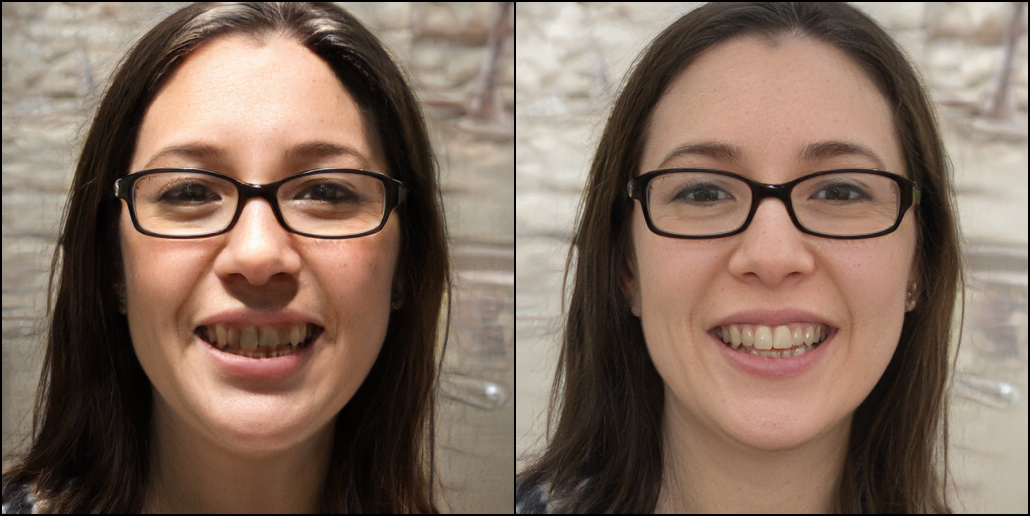

In [22]:
render_tensor([out['image'].clamp(-1, 1), out['image_albedo'].clamp(-1, 1)])

Extract the SH coefficients from the reference image

In [23]:
ref_lighting_image = to_tensor(training_set[2][0])
ref_sh = dpr.extract_lighting(ref_lighting_image).squeeze()[None, ...]

In [24]:
out = G.synthesis(ws, G.backbone.mapping_lit(None, ref_sh), camera_params, None, noise_mode='const')

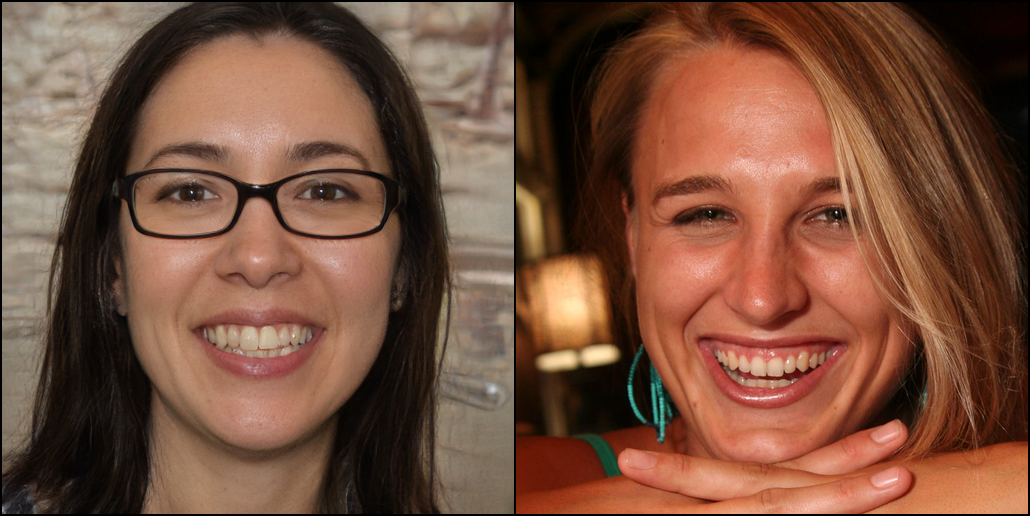

In [25]:
render_tensor([out['image'].clamp(-1, 1), ref_lighting_image])

Extract the SH coefficients from the environment map

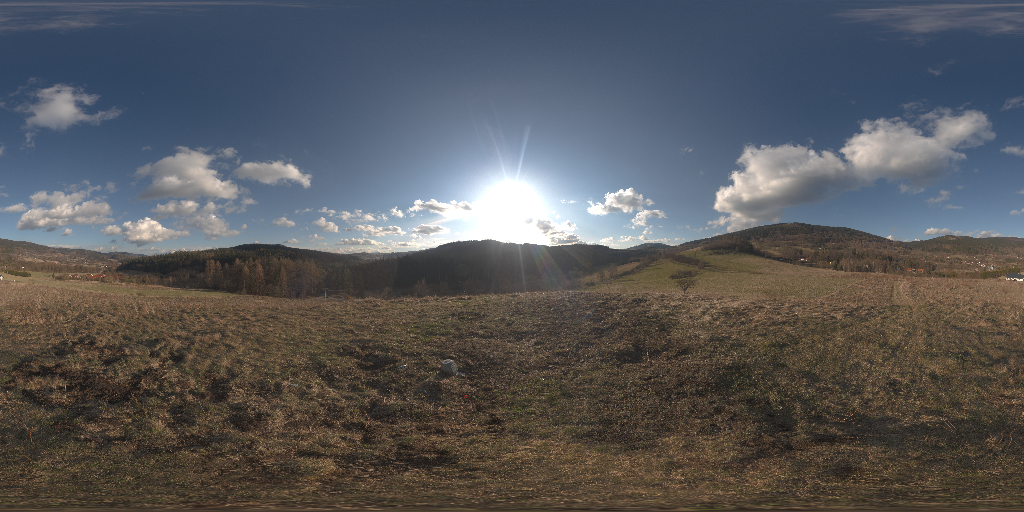

In [26]:
env_sh, env_img = get_SH_from_env('../data/hdrmap.exr')
render_tensor(env_img)

In [27]:
out = G.synthesis(ws, G.backbone.mapping_lit(None, env_sh), camera_params, None, noise_mode='const')

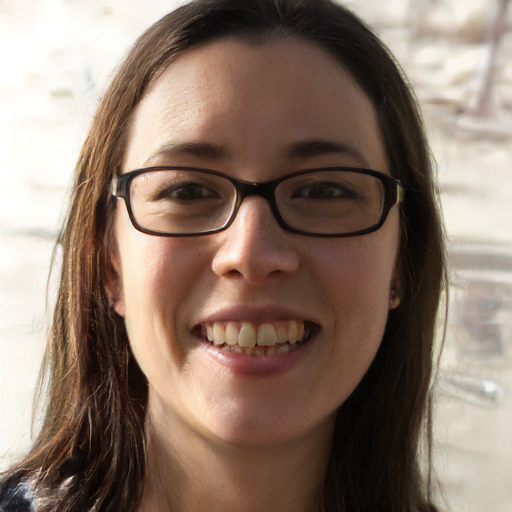

In [28]:
render_tensor([out['image'].clamp(-1, 1)])

## Shape Exportation

In [18]:
os.makedirs('./debug', exist_ok=True)

To visualize the mrc file, please refer to the *#Generating media* section of the [README](https://github.com/NVlabs/eg3d/blob/main/README.md) file of official EG3D.

In [19]:
extract_mrc('./debug/sample.mrc', G, ws)

135000000it [00:02, 61248379.50it/s]                                                                                                                                           


## Video Exportation

In [38]:
from math import floor, ceil

In [30]:
os.makedirs('./debug', exist_ok=True)

In [31]:
pitch_range = 0.25
yaw_range = 0.35
frames = 60 * 4

In [40]:
writer = imageio.get_writer('./debug/sample.mp4', mode='I', fps=60, codec='libx264')
for frame_idx in tqdm(range(frames)):
    cam2world_pose = LookAtPoseSampler.sample(
        3.14/2 + yaw_range * np.sin(2 * 3.14 * frame_idx / (frames - 1)),
        3.14/2 - 0.05 + pitch_range * np.cos(2 * 3.14 * frame_idx / (frames - 1)),
        cam_pivot, radius=cam_radius, device=device
    )
    camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    
    cursor = (len(ws_lit_s) - 1) * ( frame_idx ) / (frames - 1)
    left, right = floor(cursor), ceil(cursor)
    ws_lit = ws_lit_s[right] * (cursor - left) + ws_lit_s[left] * (1 - cursor + left)
    
    out = G.synthesis(ws, ws_lit, camera_params, None, noise_mode='const')
    writer.append_data(np.array(render_tensor([out['image'].clamp(-1, 1), out['image_albedo'].clamp(-1, 1)])))
writer.close()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 240/240 [00:19<00:00, 12.03it/s]


# Evaluation

## Fr'echet Inception Distance

Notice that there are certain randomness in the evaluation of FID.

In [88]:
metric_main.calc_metric(metric="fid50k_full", G=G, dataset_kwargs=dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset", 
    path="/path/to/recropped_FFHQ", 
    use_labels=True, 
    max_size=139914, 
    xflip=False, 
    resolution=512, 
    random_seed=0), num_gpus=1, rank=0, device=device)

{'results': {'fid50k_full': 4.047550355669591},
 'metric': 'fid50k_full',
 'total_time': 1864.4879462718964,
 'total_time_str': '31m 04s',
 'num_gpus': 1}

In [89]:
metric_main.calc_metric(metric="fid50k_clip_full", G=G, dataset_kwargs=dnnlib.EasyDict(
    class_name="training.dataset.ImageFolderDataset", 
    path="/path/to/recropped_FFHQ", 
    use_labels=True, 
    max_size=139914, 
    xflip=False, 
    resolution=512, 
    random_seed=0), num_gpus=1, rank=0, device=device)

100%|███████████████████████████████████████| 338M/338M [00:10<00:00, 32.7MiB/s]


{'results': {'fid50k_clip_full': 2.7941978278416504},
 'metric': 'fid50k_clip_full',
 'total_time': 1939.0794739723206,
 'total_time_str': '32m 19s',
 'num_gpus': 1}

## Lighting Error

In [29]:
import sys
sys.path.append("./external_dependencies/")
from external_dependencies.decalib.main import DECAWrapper
deca = DECAWrapper(device)

Load DECA and FLAME ...
trained model found. load /home/jiangkaiwen/mount/Output/35.NeRFFaceLighting-release/eg3d/external_dependencies/data/deca_model.tar
Load FAN ...
Load Face-parsing ...


Multiplier used for adjusting the predicted coefficients of DECA so that the coefficients are compatible with the definition of real spherical 
harmonics.

In [30]:
from math import pi
constant_factor = torch.tensor([
    1/np.sqrt(4*pi), ((2*pi)/3)*(np.sqrt(3/(4*pi))), ((2*pi)/3)*(np.sqrt(3/(4*pi))),\
    ((2*pi)/3)*(np.sqrt(3/(4*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3)*(np.sqrt(5/(12*pi))),\
    (pi/4)*(3)*(np.sqrt(5/(12*pi))), (pi/4)*(3/2)*(np.sqrt(5/(12*pi))), (pi/4)*(1/2)*(np.sqrt(5/(4*pi)))]).float().to(device)

constant_factor[0] /= (0.5 * np.sqrt(1/np.pi))

constant_factor[1] /= (np.sqrt(3/(4*np.pi)))
constant_factor[2] /= (np.sqrt(3/(4*np.pi)))
constant_factor[3] /= (np.sqrt(3/(4*np.pi)))

constant_factor[4] /= (0.5 * np.sqrt(15 / np.pi))
constant_factor[5] /= (0.5 * np.sqrt(15 / np.pi))
constant_factor[6] /= (0.5 * np.sqrt(15 / np.pi))
constant_factor[7] /= (0.25 * np.sqrt(15 / np.pi))
constant_factor[8] /= (0.25 * np.sqrt(5 / np.pi))

In [41]:
mse_s = []
random_state = np.random.RandomState(0)
for _ in tqdm(range(0, 2000, 2)):
    image = training_set[_][0]
    realdict = deca.encode(Image.fromarray(image.transpose(1, 2, 0)))
    camera_params = torch.from_numpy(training_set.get_label(_)[0]).to(device)[None, ...]
    
    z = torch.from_numpy(random_state.randn(1, G.z_dim)).to(device)
    ws = G.backbone.mapping(z, conditioning_params, 1.)
    ws_lit = G.backbone.mapping_lit(None, torch.from_numpy(training_set.get_label(_)[1]).to(device)[None, ...])
    out = G.synthesis(ws, ws_lit, camera_params, None)
    try:
        decadict = deca.encode(render_tensor(out["image"].clamp(-1, 1)))
    except Exception:
        continue

    mse_s.append(((realdict['light'] - decadict['light']) * constant_factor[None, :, None]).square().sum(dim=1).sqrt().mean().item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [04:45<00:00,  3.50it/s]


0.6372272987663746


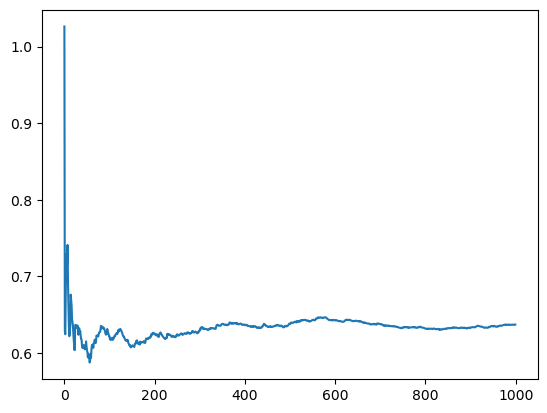

In [42]:
print(sum(mse_s) / len(mse_s))
plt.plot(list(range(len(mse_s))), [sum(mse_s[:_])/_ for _ in range(1, len(mse_s)+1)])

## Lighting Error_unseen

Multiplier used for adjusting the predicted coefficients of *Deep Single Image Portrait Relighting* so that the coefficients are compatible with the definition of real spherical 
harmonics.

In [96]:
att = np.pi*np.array([1, 2.0/3.0, 1/4.0])
sh_basis = np.zeros((1, 9))
sh_basis[:,0] = 0.5/np.sqrt(np.pi)*att[0] / (0.5*np.sqrt(1/np.pi))

sh_basis[:,1] = np.sqrt(3)/2/np.sqrt(np.pi)*att[1] / (np.sqrt(3/(4*np.pi)))
sh_basis[:,2] = np.sqrt(3)/2/np.sqrt(np.pi)*att[1] / (np.sqrt(3/(4*np.pi)))
sh_basis[:,3] = np.sqrt(3)/2/np.sqrt(np.pi)*att[1] / (np.sqrt(3/(4*np.pi)))

sh_basis[:,4] = np.sqrt(15)/2/np.sqrt(np.pi)*att[2] / (0.5 * np.sqrt(15 / np.pi))
sh_basis[:,5] = np.sqrt(15)/2/np.sqrt(np.pi)*att[2] / (0.5 * np.sqrt(15 / np.pi))
sh_basis[:,6] = np.sqrt(5)/4/np.sqrt(np.pi)*att[2] / (0.25 * np.sqrt(5 / np.pi))
sh_basis[:,7] = np.sqrt(15)/2/np.sqrt(np.pi)*att[2] / (0.5 * np.sqrt(15 / np.pi))
sh_basis[:,8] = np.sqrt(15)/4/np.sqrt(np.pi)*att[2] / (0.25 * np.sqrt(15 / np.pi))

In [98]:
celeba_hq_dir = "/path/to/CelebA-HQ/"
celeba_fn_s = list(filter(lambda fn: fn.endswith('.jpg') or fn.endswith('.png'), sorted(os.listdir(celeba_hq_dir))))

In [100]:
celeba_sh_s = []
for fn in tqdm(celeba_fn_s):
    celeba_sh_s.append(dpr.extract_lighting(to_tensor(Image.open(os.path.join(celeba_hq_dir, fn)))).detach().cpu().numpy())

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 29232/29232 [19:32<00:00, 24.93it/s]


In [105]:
celeba_sh_s = np.stack(celeba_sh_s).reshape(-1, 9)
_, ffhq_sh_s = training_set._get_raw_labels()
ffhq_sh_s_mean = ffhq_sh_s.mean(axis=0)[None, ...]
celeba_topk = sorted(list(zip(((((celeba_sh_s - ffhq_sh_s_mean) * sh_basis)**2).sum(axis=1)**0.5).tolist(), list(range(celeba_sh_s.shape[0])))), reverse=True)

In [106]:
mse_s = []
random_state = np.random.RandomState(0)

for idx in tqdm(range(0, 1000)):
    image = Image.open(os.path.join(celeba_hq_dir, celeba_fn_s[celeba_topk[idx][1]]))
    try:
        realdict = deca.encode(image)
    except Exception:
        continue
    
    sh = torch.from_numpy(celeba_sh_s[celeba_topk[idx][1]])[None, ...].to(device)
    cam2world_pose = LookAtPoseSampler.sample(np.pi/2-realdict['pose'][0, 1], np.pi/2-realdict['pose'][0, 0], cam_pivot, radius=cam_radius, device=device)
    camera_params = torch.cat([cam2world_pose.reshape(-1, 16), intrinsics.reshape(-1, 9)], 1)
    
    z = torch.from_numpy(random_state.randn(1, G.z_dim)).to(device)
    ws_geo = G.backbone.mapping(z, conditioning_params, 1.)
    ws_lit = G.backbone.mapping_lit(None, sh)
    out = G.synthesis(ws_geo, ws_lit, camera_params, sh, noise_mode='const')
    
    try:
        decadict = deca.encode(render_tensor(out["image"].clamp(-1, 1)))
    except Exception:
        continue
    
    mse_s.append(((realdict['light'] - decadict['light']) * constant_factor[None, :, None]).square().sum(dim=1).sqrt().mean().item())

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:09<00:00,  3.24it/s]


0.6474757246479004


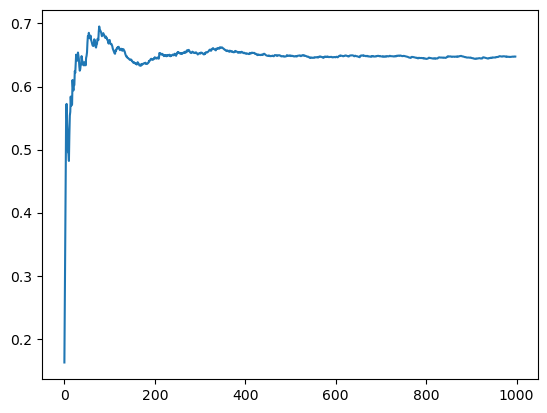

In [108]:
print(sum(mse_s) / len(mse_s))
plt.plot(list(range(len(mse_s))), [sum(mse_s[:_])/_ for _ in range(1, len(mse_s)+1)])

## Lighting Stability

In [117]:
random_state = np.random.RandomState(0)
std_s = []
for _ in tqdm(range(0, 2000, 2)):
    camera_params = torch.from_numpy(training_set.get_label(_)[0]).to(device)[None, ...]
    
    lighting_s = []
    for idx in range(100):
        z = torch.from_numpy(random_state.randn(1, G.z_dim)).to(device)
        ws = G.backbone.mapping(z, conditioning_params, 1.)
        ws_lit = G.backbone.mapping_lit(None, torch.from_numpy(training_set.get_label(_)[1]).to(device)[None, ...])
        out = G.synthesis(ws, ws_lit, camera_params, None, noise_mode='const')
        try:
            decadict = deca.encode(render_tensor(out["image"].clamp(-1, 1)))
        except Exception as e:
            continue
        lighting_s.append((decadict['light'] * constant_factor[None, :, None]).detach().cpu().numpy())
    if len(lighting_s) <= 0:
        continue
    lighting_s = np.concatenate(lighting_s, axis=0)
    lighting_s = lighting_s.std(axis=0).mean()
    std_s.append(float(lighting_s))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [4:05:19<00:00, 14.72s/it]


0.14567625821381808


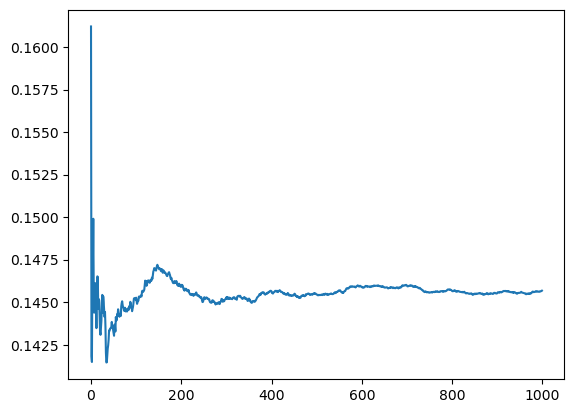

In [118]:
print(sum(std_s) / len(std_s))
plt.plot(list(range(len(std_s))), [sum(std_s[:_])/_ for _ in range(1, len(std_s)+1)])